In [1]:
from functools import partial

import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from src.utils import generate_y
from src.MLP import MLP

## Tutorial for `Type2` problem

The usage of `type 1` problems are prominent. However it is often true that without constraints on optimization varaibles $x$ that the optimal solution might be trivial.
As an concrete example, let's consider the following optimization problem:
$$ \max_{x} x^2 $$

We can visually inspect the solution of above optimization problem. Let's look around the following figure

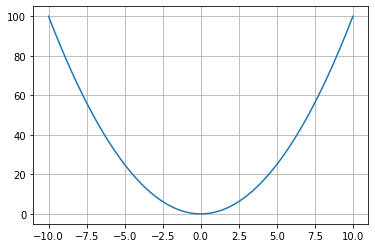

In [2]:
xs = np.linspace(-10.0, 10.0, 1000)
ys = xs ** 2
fig, ax = plt.subplots(1,1)
ax.grid()
_ = ax.plot(xs, ys)

As you can notice, as we push the solution $x$ toward $\infty$ or $-\infty$, the objective function $x^2$ increase. We call this scenarios as 'the problem is unbounded'. Even in the practical setup, we will confront such cases easily. Moreover to make the optimization problem 'practically' useful, we can consider the constrain on to the optimization problem. We firstly consider the following type of constraint optimziation problem.

### Solve optimization problem with box constraints

$$
\begin{aligned}
 \min_{x} &\, f(x) \\
 \text{s.t.} &\, x_{min} \leq x \leq x_{max} \\
\end{aligned}
$$

This type of optimization problem is to handle the box constraint on optimization variable $x$. The $\text{s.t.}$ is abbreviation of '**s**uch **t**hat'.

#### Box constraint

$$x_{min} \leq x \leq x_{max}$$

The box constraint indicates that the solution of optmization problem $x^*$ must be larger or equal to $x_{min}$ and smaller or equal to $x_{max}$. The box constraint is a special case of general constraints. Mathemacically to solve the optimziation problems, either the box constraint and general linear/non linear constraints can be handled in the same manner. However most of the off-the-shelf solvers explictly consider the box constrains as a different arguments from the other constraints. 

> For instance, `scipy` solvers consider the box constrains as `bounds`.

For now, let's investigate the box constraint first and reserve some room for the general constraint. 

## `scipy.optimize` pacakge

`scipy.optimize` is a package that implements various types of optimziation solvers. Most importantly, they offer nice python interface of the solvers so that you can setup your own optmization problem with few lines of codes. We will also solve the optimization problems with a variant of QP solver of this package.

Especially, `scipy.optmize.minize` function is powerful in practice. you can 'some-how-magically' optimize your own function. Even in the case your function is not analytically differntiable.

> In such case, `scipy.optmize.minize` employs numerical methods to estimate the jacobian and hessian. As a cost of emplyoing numerical methods, the optmization procedure will be slower.

### Interface of `scipy.optimize.minimize`

`scipy.optimize.minimize` majorly requires following arguments:

1. `fun`: the objective function that you want to optmize
2. `x0`: the initial solution. You can set arbitarily unless it doesn't violate constraints
3. `jac`: (optional) the method for computing the jacobian of the objective function
4. `hessian`: (optional) the method for computing the hessian of the objective function
5. `bounds`: (optional) box constraints
6. `constraints`: (optional) linear/non-linear constraints

when `jac` and `hessian` is not specified, the `scipy.optmize.minize` function estimate the jacobian and hessian of the objective function numerically.

## Implementing `fun`, `jac`, `hessian`

Our primiary interest is to bind the `torch` module and `scipy.optimize.minimize`. Since pytorch is automatic differentiation tool, we can compute the `jac` and `hessian` efficiently.

In [3]:
def objective(x, model):
    # Note that we will not use the pytorch's automatic differentiation functionality
    # while computing objective
    with torch.no_grad(): 
        torch_x = torch.from_numpy(x).view(-1,1).float()
        y = model(torch_x)
        y = y.sum().numpy()
    return y

def jac(x, model):
    torch_x = torch.from_numpy(x).view(-1,1).float()
    jac = torch.autograd.functional.jacobian(model, torch_x).numpy()
    return jac

In [4]:
m = MLP(1, 1, num_neurons=[128, 128])
m.load_state_dict(torch.load('./model.pt'))

<All keys matched successfully>

In [5]:
lb, ub = -3.0, 2.0 # declare lower and upper bound of optmization variable

x_init = np.random.uniform(lb, ub) 
x0 = np.ones(1) * x_init
x0_tensor = torch.ones(1,1) * x_init
y0 = m(x0_tensor).detach()

In [6]:
b = (lb, ub)
bnds = (b,)

soln_nn = minimize(partial(objective, model=m), 
                   x0, 
                   method='SLSQP', 
                   bounds=bnds, 
                   jac=partial(jac, model=m))

## Visualize optimization result

In [7]:
x_min, x_max = -4.0, 4.0

xs_linspace = torch.linspace(-4, 4, 2000).view(-1, 1)
ys_linspace = generate_y(xs_linspace)

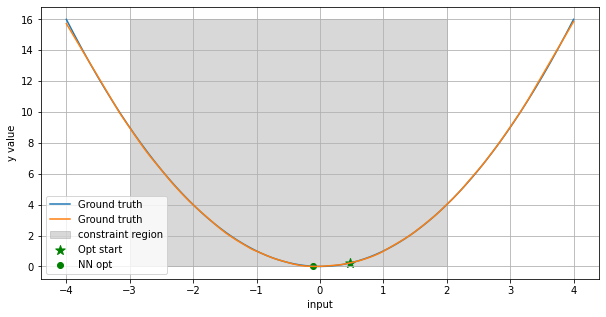

In [8]:
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
axes.grid()
axes.plot(xs_linspace, ys_linspace, label='Ground truth')

ys_pred = m(xs_linspace).detach()
axes.plot(xs_linspace, ys_pred, label='Ground truth')
axes.fill_between(np.linspace(lb, ub, 100),
                  ys_linspace.min(),
                  ys_linspace.max(),
                  color='grey', 
                  alpha=0.3,
                  label='constraint region')
axes.scatter(x_init, y0, label='Opt start', 
             c='green', marker='*', s=100.0)

axes.scatter(soln_nn.x, soln_nn.fun, label='NN opt', c='green')
axes.legend()
axes.set_xlabel("input")
axes.set_ylabel("y value")
plt.show()